In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import iplot, init_notebook_mode

%matplotlib inline 

In [22]:
# enable hide code, default true 
from IPython.display import HTML

HTML('''<script>
code_show = true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="toggle code on/off"></form>''')

In [23]:
# Change default markdown styles 
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:0.05em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 1.8em;
line-height:1.3em;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}

div.text_cell_render { /* Customize text cells */
font-size:1.2em;
line-height:1.3em;
}
</style>
""")

# 120 Years Later
### Insights from analysing Kaggle's Olympic History data set 
<img src="images/rings.png">
*Klaudia Ludwisiak * <br>
13 December 2018



__Task:__ Analyse the Olympic data set and produce noteworthy insights

<br> 
__Motivation__ for presenting this project:


- Showcase skills: exploratory data analysis, data pre-processing, visualisation and machine learning. 



- __Relevance to McLaren:__
    - Human Performance program.
    - McLaren AT involved in the 2012 London Games.
    - Idea of sport and competition at the heart of the company.



# Roadmap:
<br>


1)  Introduction: Methods, data set, cleaning, augmentation.  <br>

2)  Mini Literature review: What is already known about the Olympics ? <br>

3)  Closer look at Europe in the Olympics. <br>

4)  Can predict if an athlete will win a medal ? <br>

5)  Can predict number of medals a European country will win ? 

# Introduction 


### Raw Data 

<br>
__Source:__ Kaggle data set 

__Time Span:__ from 1896 to 2016.

__271,116 rows__ corresponding to individual athletes.

__15 features__ specific to: athlete, sport, country and the olympiad.

<br>
__ Challenges: large data set, high level of granularity, multiple data types.  __


### Approach 

<br>
*Language:* <br>
python --> popular, concise, rich ML and stats libraries <br>
<br>
*Implementation: *<br> 
jupyter notebooks --> easily put together code, statistics, text and graphs.<br>
<br>
*Packages:* 
- pandas --> efficiently manipulate data (group, pivot, aggregate), store features with different data types, reference features with column names  
- plotly --> make interactive visualisation with hover functionality 
- sklearn and statmodels --> machine learning / statistics models 


## Data Cleaning

<br>

__Issue: __ <br>
How to fill missing height, weight and age data ? <br>

__Observe:__<br> 
Age, Height and Weight differ with gender, time and sport discipline.



__Action:__ <br>
Group by sport, gender and year. Fill missing values with group mean values. 


In [4]:
df4plot = pd.read_csv('images/df4plot1.csv')
init_notebook_mode(connected=True)

data = []
for sport in df4plot['Sport']:
    ds = df4plot[df4plot['Sport']==sport]
    trace = go.Scatter(x = ds['Height'],y = ds['Weight'], name = sport,
                       marker = dict(symbol='circle',
                                   sizemode ='area',
                                   sizeref = 7,
                                   size = ds['ID'],))
    data.append(trace)
                         
layout = go.Layout(title='Athletes average body metrics by sport',height=600, width=800,autosize=False,
                   xaxis=dict(title ='Height (cm)'),
                   yaxis=dict(title ='Weight (kg)'),
                   showlegend=False, hovermode='closest')

fig = dict(data = data, layout = layout)

iplot(fig, filename='Ave_body_metrics_by_sport')

In [5]:
#clean = pd.read_csv('all_data/clean_data.csv')
clean = pd.read_csv('all_data/extended_data.csv')

## Data Augmentation: 
<br>

1) Add mappings: City --> Country --> Region 


<br>
2) Add GDP by Country and year 


<br>
3) Add Population by Country and year <br>

<br>
Additions occurred gradually and allowed to focus the analysis on 'Europe in the Olympics' as well as have a go at varied prediction problems. 

# Mini Literature Review 

<br>
What has already been discovered about the Olympics using this data set ?

<br>
Widely explored topics:

- Olympic History and World History 


- Woman at the Olympics


- Olympic Disciplines and their relationship with body metrics


- Geographic Participation


- Top Countries by absolute medal count  

In [6]:
init_notebook_mode(connected=True)
sth = clean.groupby(['Year', 'City'])['Season'].value_counts()
df4plot = pd.DataFrame(data={'Num_Athletes': sth.values}, index = sth.index).reset_index()
df_Summer = df4plot[df4plot['Season']=='Summer'] 
df_Winter = df4plot[df4plot['Season']=='Winter']
init_notebook_mode(connected=True)

traceS = go.Bar(x = df_Summer['Year'],y = df_Summer['Num_Athletes'],name="Summer Games",text= df_Summer['City'],
                marker=dict(color='rgb(270,180,0)',opacity=1,))

traceW = go.Bar(x = df_Winter['Year'],y = df_Winter['Num_Athletes'],name="Winter Games",text= df_Winter['City'],
                marker=dict(color='rgb(20,200,255)'))

layout = dict(title = 'Number of Athletes in Olympic Games',height=600, width=800,autosize=False,
          xaxis = dict(title = 'Year', showticklabels=True), 
          yaxis = dict(title = 'Number of athlets'),
          legend=dict( x=0.08,y=0.93, traceorder='normal', bgcolor='#E2E2E2',bordercolor='#FFFFFF',borderwidth=2), 
          barmode='stack')

fig = dict(data= [traceS, traceW], layout=layout)
iplot(fig, filename='Number_athletes_olympiads')

In [7]:
# create df with a medal count by type of medal and country
medals = pd.DataFrame(clean.groupby('Medal')['Country'].value_counts())\
                .rename(columns={'Country':'Medal_Count'}).reset_index() 
                # Out: 3 columns: Medal/Country/Medal count (by type of medal)

# make pivot table with country as rows and medal type as collumn, fill missing values with zero (no medals)
medals_piv = medals.pivot(index='Country',columns='Medal').fillna(0)

# add total medals column and total overall (number of athletes participating)
medals_piv['Total_Medals'] = medals_piv.Medal_Count.Bronze + medals_piv.Medal_Count.Silver \
                            + medals_piv.Medal_Count.Gold
medals_piv['Total_Athletes'] = medals_piv.Medal_Count.sum(axis=1)

# add column for total medals won as a % of total athelet participants 
medals_piv['%medalists'] = round(100* medals_piv['Total_Medals']/medals_piv['Total_Athletes'],1)

# sort data frame in descending order using the total medals column
medals_piv = medals_piv.sort_values(by='Total_Medals',ascending=False)

traceG = go.Bar(x = medals_piv.index, y = medals_piv.Medal_Count.Gold.head(15).values, name="Gold",
               marker=dict( color='rgb(212,175,55)', opacity=0.7, reversescale = True))

traceS = go.Bar(x = medals_piv.index, y = medals_piv.Medal_Count.Silver.head(15).values, name="Silver",
               marker=dict( color='rgb(192,192,192)', opacity=1, reversescale = True))

traceB = go.Bar(x = medals_piv.index, y = medals_piv.Medal_Count.Bronze.head(15).values, name="Bronze",
               marker=dict( color='rgb(128,0,0)', opacity=0.5, reversescale = True))

trace_perc = go.Scatter(x= medals_piv.index , y = medals_piv['%medalists'].head(15).values,name="%_Medalists",  
                        yaxis='y2',marker=dict(color="Blue"),mode = "markers")

layout = go.Layout(title='Top Countries by Medals Won; in absolute and % terms', height=600, width=800, autosize=False,                   yaxis = dict(title = 'Number of Medals'),
                   yaxis2 = dict(title='% Medals won out of all attempts', anchor='x',overlaying='y',side='right'),
                   legend=dict( x=0.78,y=1, traceorder='normal',font=dict(color='#000'), bgcolor='#F2E2E2',
                               bordercolor='#FFFFFF',borderwidth=2), 
                   barmode='group')

fig = go.Figure(data = [traceG ,traceS ,traceB ,trace_perc], layout = layout)
iplot(fig, filename = "medal")  

 __How many countries have never won an Olympic medal ? __

    Out of 209 participating countries, 72  never won an Olympic Medal, that is 35% !

 __ Which countries are those? __

In [8]:
NoMedal = medals_piv.tail(72)
NoMedal.reset_index(inplace=True)

trace = go.Choropleth(locations = NoMedal.Country,
                      locationmode='country names', 
                      z = NoMedal.Total_Athletes,
                      colorscale = 'Blues',                      
                      reversescale = True,
                      text = NoMedal.Country,
                      marker = dict( line = dict(color = 'gray',width = 0.5)),
                      colorbar = dict(title = '#Athlete Attempts'))

layout = go.Layout(title = 'Countries without an Olympic Medal', height=600, width=800,autosize=False,
                   geo = dict(projection = dict( type = 'equirectangular')),
                   hovermode='closest')

fig = dict(data = [trace], layout = layout)
iplot(fig,filename='noMedal_Choropleth')

# Europe in the Olympics 

#### Assumption:    What constitutes 'Europe'?

Only consider those countries whose territories lie fully within the European continent. 

#### Acknowledge:    Data inconsistencies in Yugoslavian and Czechoslovakian data

- All medals won by Czechoslovakia are attributed to modern-day Czech Republic and none to Slovakia.


- Similarly, all medals won by Yugoslavia are attributed to modern-day Serbia. Without provisions for Slovenia, Croatia, Bosnia and Herzegovina, Montenegro or Kosovo. 

## European Olympic events; frequency and location

<br>        
 <br> 
<h6><center>
Europe hosted 29 of all 51 Olympic games held in modern history; this is 56%
</center></h6>


In [9]:
# make data for plot 
tmp =  clean[clean.Host_Continent=='Europe'].groupby(['Host_Country'])['Games'].nunique()

init_notebook_mode(connected=True)

trace = [go.Choropleth(locations = tmp.index,
                      locationmode='country names', 
                      z = tmp,
                      colorscale = 'Greens',                      
                      reversescale = True,
                      text = tmp.index,
                      marker = dict( line = dict(color = 'gray',width = 0.5)),
                      colorbar = dict(title = '#Olympics hosted'),         
                      geo = 'geo2')]
layout = go.Layout(
    title = 'European Olympic Hosts', height=600, width=800,autosize=False,
    geo = dict( scope = 'europe',projection = dict(type = 'mercator')),
    geo2 = dict(scope = 'europe',
        showframe = False,
        showland = True,
        landcolor = "rgb(229, 229, 229)",
        showcountries = False),
        legend = dict(traceorder = 'reversed'))

fig = dict(data = trace, layout = layout)
iplot(fig,filename='world_Choropleth')

## European teams 
<br>
Interested in recent statistics, so use data since 2006 (last 3 Olympiads). 


<br>
*How big are they ?  *

<br>
*What is the ratio of Man to Woman in the different European teams ? *

In [10]:
# make a df of european teams 
team_europe = clean[clean.Continent == 'Europe']#.groupby(['Country',])
# group by Year and Contry. Count number of athletes 
sth = team_europe.groupby(['Year', 'Country'])['Season'].value_counts()
df4plot = pd.DataFrame(data={'Num_Athletes': sth.values}, index = sth.index).reset_index()
# split up into recent yrs by season, for ease of calculation and plotting
df_Summer = df4plot.query('Season == "Summer" & Year >=2006')
df_Winter = df4plot.query('Season == "Winter" & Year >=2006')
df_Summer = df_Summer.groupby(['Country'])['Num_Athletes'].mean().sort_values(ascending=False)
df_Winter =  df_Winter.groupby(['Country'])['Num_Athletes'].mean()
# group by Contry. Count number of athletes and include Sex
sth = team_europe.query('Year >=2006').groupby(['Country'])['Sex'].value_counts() # change here!
df4plot = pd.DataFrame(data={'Num_Athletes': sth.values}, index = sth.index).reset_index()
# Make DF with ratio of Male to Female european Athletes
df_M = df4plot.query('Sex == "M"').copy()
df_F = df4plot.query('Sex == "F"').copy()
df_M.rename(columns={'Num_Athletes':'Num_Athletes_M'},inplace=True)
df_F.rename(columns={'Num_Athletes':'Num_Athletes_F'},inplace=True)
df_M.drop('Sex',axis=1,inplace=True)
df_F.drop('Sex',axis=1,inplace=True)
df = df_M.merge(df_F, on='Country' )
df['M:F_ratio']= df.Num_Athletes_M / df.Num_Athletes_F

In [11]:
#init_notebook_mode(connected=True)

traceS = go.Bar(x = df_Summer.index, y = round(df_Summer,1) ,name="Summer Games",
                marker=dict(color='rgb(270,180,0)',opacity=1,))

traceW = go.Bar(x = df_Winter.index ,y = round(df_Winter,1),name="Winter Games",
                marker=dict(color='rgb(20,200,255)'))

trace_ratio = go.Scatter(x = df.Country , y = df['M:F_ratio'],name="M:F_ratio",
                        yaxis='y2',marker=dict(color="Blue"),mode = "markers")

layout = dict(title = 'Ave. Number of European Athletes in Olympics since 2006 and gender ratio',
              height=600, width=800, autosize=False,
          xaxis = dict(title = 'Country', showticklabels=True,  tickangle = 45, tickfont=dict(size=9)), 
          yaxis = dict(title = 'Number of athlets'),
          yaxis2 = dict(title='Number of Males per 1 Female', anchor='x',overlaying='y',side='right'),
          legend=dict(x=0.4,y=0.95, traceorder='normal',font=dict(color='#000'), bgcolor='#E2E2E2'))

fig = dict(data= [traceS, traceW, trace_ratio], layout=layout)
iplot(fig, filename='Number_athletes_olympiads')

## 'Best' European Countries by Medal Count and Sport

<br>
####  Medal count 
 
- Nine European countries made it into the top 15 in the world, thats almost 60%! 
<br>
__ Germany, UK, France, Italy, Sweden, Hungary, Netherlands, Norway, Finland.  __ 


- Five European countries never won a medal.


- Remarkably, Kosovo, which is the 'youngest' European country has won one medal in Judo.

In [12]:
# create df with a medal count by type of medal and country
medals = pd.DataFrame(team_europe.groupby(['Country','Sport','Season'])['Medal'].value_counts())\
                .rename(columns={'Medal':'Medal_Count'})
    
# make pivot table, fill missing values with zero (no medals)
medals_piv = medals.pivot_table(values='Medal_Count',index=['Country','Sport','Season'],columns='Medal').fillna(0)

# add total medals column and total overall (number of athletes participating)
medals_piv['Total_Medals'] = medals_piv.Bronze + medals_piv.Silver  + medals_piv.Gold

C_S = medals_piv.reset_index().copy()
Summer = C_S.query('Season == "Summer"')
Winter = C_S.query('Season == "Winter"')

In [13]:
from plotly import tools

trace_Summer = go.Heatmap(z = Summer.Total_Medals, y = list(Summer.Sport) , x = list(Summer.Country), name = 'Summer Games',
                   colorscale = 'Viridis', reversescale = True, colorbar = dict(title = '#Total Medals',x = 0.43))

trace_Winter = go.Heatmap(z = Winter.Total_Medals, y = list(Winter.Sport) , x = list(Winter.Country), name = 'Winter Games',
                   colorscale = 'Blues', reversescale = True, colorbar = dict(title = '#Total Medals'))

fig = tools.make_subplots(rows=1, cols=2, print_grid=False, subplot_titles=('Summer Games', 'Winter Games'))

fig.append_trace(trace_Summer, 1, 1)
fig.append_trace(trace_Winter, 1, 2)

fig['layout']['xaxis1'].update(title='Country', showgrid=False,  domain=[0.025, 0.425], tickangle = 45, tickfont=dict(size=9))
fig['layout']['xaxis2'].update(title='Country', showgrid=False,  domain=[0.585, 1], tickangle = 45, tickfont=dict(size=8))

fig['layout']['yaxis1'].update(title='Sport', showgrid=False, tickangle = 345, tickfont=dict(size=8))
fig['layout']['yaxis2'].update(title='Sport',showgrid=False, tickangle = 345, tickfont=dict(size=9))
                          
fig['layout'].update(height=800, width=1600, autosize=False,
                     title='European Medals by Country and Sport')

iplot(fig, filename='euro_heatmap')

## European athlete's body metrics and Olympic success 

<br><br>
*How do Athlete's average body metrics vary by Country ?*

In [14]:
df1 = team_europe.groupby(['Country'])['Height', 'Weight'].agg('mean').dropna().reset_index()
df2 = team_europe.groupby(['Country'])['ID'].count().reset_index() 
df4plot = df1.merge(df2)

hover_text = []
for index, row in df4plot.iterrows():
    hover_text.append(( 'Country: {}<br>'+
                        'Mean Height: {}<br>'+
                        'Mean Weight: {}<br>'+
                        'Number of athlets: {}<br>').format(row['Country'],
                                                            round(row['Height'],2),
                                                            round(row['Weight'],2), 
                                                            row['ID']))
df4plot['hover_text'] = hover_text

In [15]:
data = []
for country in df4plot['Country']:
    ds = df4plot[df4plot['Country']==country]
    trace = go.Scatter(x = ds['Height'],y = ds['Weight'], name = country,  text = ds['hover_text'],
                       marker = dict(symbol='circle',
                                   sizemode ='area',
                                   sizeref = 7,
                                   size = ds['ID'],))
    data.append(trace)
                         
layout = go.Layout(title='Athletes average body metrics by country',
                   height=600, width=800, autosize=False,
                   xaxis=dict(title ='Height (cm)'),
                   yaxis=dict(title ='Weight (kg)'),
                   showlegend=False, hovermode='closest')

fig = dict(data = data, layout = layout)

iplot(fig, filename='Ave_body_metrics_by_country')

__Fun fact:__ World's 10 tallest nations are all European! [1] 

<br> 
__ Recall: __ General rule of thumb for Olympic success: *the taller and thinner the better*.
Especially true for hand-ball sports, rowing, canoeing and ice hockey

<br>
__Conclude:__ 5 of the top 10 tallest countries excel in sport disciplines especially favouring the tall and are all on the right hand side of the plot.  

In [16]:
# Load full data for europe since 1995
europe95 = pd.read_csv('all_data/europe95.csv')
europe95.drop('Unnamed: 0',axis=1,inplace=True)

In [17]:
europe95.drop(['ID', 'Name','Team','NOC', 'Games', 'Year','City','Event'] ,axis=1,inplace=True)
europe95.drop(['Host_Country','Continent','sub_Continent','Host_Continent', 'Host_sub_Continent'],axis=1,inplace=True)
# make target
europe95.loc[europe95.Medal == 'No_Medal','Target']= 0
europe95.loc[europe95.Medal != 'No_Medal','Target']= 1

## Relationship between GDP, population and medal count? 

<BR>

Looking at Europe, from 1995 onwards, where reliable figures for all modern-day European countries exist. 

In [18]:
forplot = europe95.groupby(['Country'])[['Target','GDP','Population']].agg({'Target':'sum','GDP':'mean',\
                                                                            'Population':'mean'})

init_notebook_mode(connected=True)

forplot.reset_index(inplace=True)

trace1 = go.Scatter( x= forplot['GDP'], y = forplot['Target'], mode='markers', text = forplot.Country, \
                    name = 'GDP', textposition='top left')

trace2 = go.Scatter(x = forplot['Population'], y = forplot['Target'],  name = 'Population',
                       xaxis='x2',yaxis='y2',  mode='markers', text = forplot.Country, textposition='top left')

fig = tools.make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout']['xaxis1'].update(title='Ave GDP')
fig['layout']['xaxis2'].update(title='Ave Population')

fig['layout']['yaxis1'].update(title='#Medals')
#fig['layout']['yaxis2'].update(title='Sport',tickangle = 345, tickfont=dict(size=9))

fig['layout'].update(height=550, width=800, title='GDP and Population vs Athlete medals by country')
iplot(fig, filename='GDP and Population vs athlete medals by country')

### Conclusions
<br>
Key findings about Europe in the Olympics:
 
- Since 1896, Europe hosted 56% of all Olympic games, across 14 countries.  


- Many of the tallest European nations specialise in sports favouring the tall.


- Positive correlation between a country's GDP, population and the number of medals won exists.
    

# Can we predict if an athlete will win a medal? 

<br>
This is an ambitious prediction goal!

### What meaningful features can be extracted from the data?

- continuous features: __Height, Weight, Age, Population, GDP __


- categorical features: __Season, Gender, Country, Sport__

    - for binary categorical features use label encoding, else use one hot encoding 

<br>
Binary classification setting; minority class constitutes 12.6% of the data set

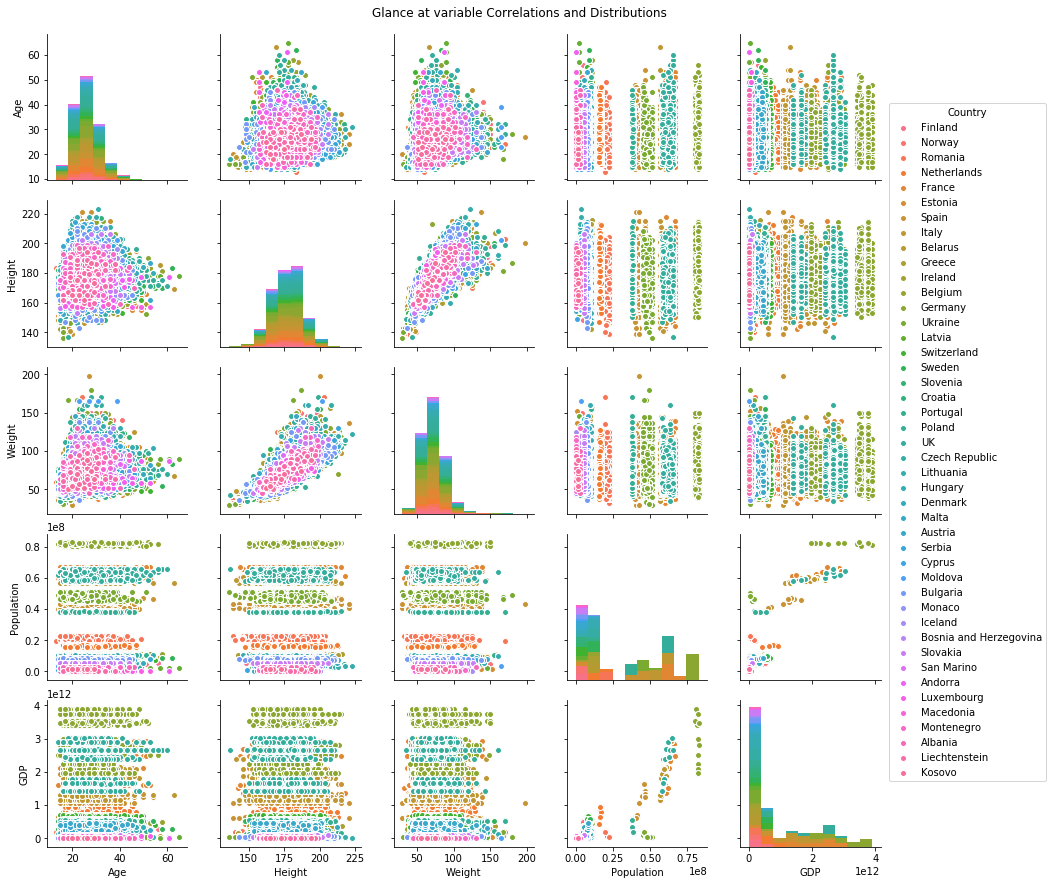

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#sns.pairplot(europe95, hue="Country")
sns.pairplot(europe95.drop(['Medal','Target'],axis=1), hue="Country")
plt.subplots_adjust(top=0.95)
plt.suptitle('Glance at variable Correlations and Distributions')
plt.show()

### Result

Evaluation metric: Recall --> want to capture all potential medal winners
 
__Random Forest__ Classifier --> simplest model that does the job.

__Recall score: 0.47,  
Precision score: 0.64.        
Accuracy score: 0.90__

Thus, the model identifies 47% of all medalist, with an accuracy approx. 3% higher than always predicting the majority class.

        Feature importances: 
        1) Population     0.16
        2) GDP            0.14
        3) Weight         0.13
        4) Age            0.12
        5) Height         0.11
        6) Sex_cat        0.04
        7) Handball       0.02
        8) Hockey         0.014
        9) Netherlands    0.0132
        10) Football       0.0130

# Can we predict something else? 
<br>
Previous prediction task is too ambitious given the limited data...


__Intuition: __ there is a strong relationship between country size (GDP and population), number of athletes participating in the games and the number of medals won. 
<br>



##  How many medals will a European country win? 

Problem changes from a Classification to a Regression setting 
<br>
### What meaningful features can be extracted from the data?
   - Continuous features per country: GDP, Population, GDP per capita, number of Athletes 
    
   
   - Categorical features: Season (Summer/ Winter)
    

In [20]:
# Load Clean data 
take2 = pd.read_csv('all_data/europe95.csv')
take2.drop('Unnamed: 0',axis=1,inplace=True)
# make target
take2.loc[take2.Medal == 'No_Medal','Target']= 0
take2.loc[take2.Medal != 'No_Medal','Target']= 1
# Add per capita GDP
take2['GDP_per_Cap'] = round(take2['GDP']/take2['Population'],2)
#group
grouped = take2.groupby(['Country','Year','Season','GDP','Population','Host_Country','GDP_per_Cap'])['Target','ID']\
.agg({'Target':'sum','ID':'count'})
grouped.rename(columns={'ID':'Num_Athletes'},inplace=True)
grouped.reset_index(inplace=True)
grouped['Home_adv'] = np.where(grouped['Host_Country'] == grouped['Country'], 1, 0)
grouped['Season_cat'] = np.where(grouped['Season'] == 'Summer', 1, 0)
# take the log transforms for the variables
grouped['Log_Population'] = np.log(grouped['Population'])
grouped['Log_GDP'] = np.log(grouped['GDP'])
grouped['Log_Num_Athletes'] = np.log(grouped['Num_Athletes'])
grouped['Log_GDP_per_Cap'] = np.log(grouped['GDP_per_Cap'])

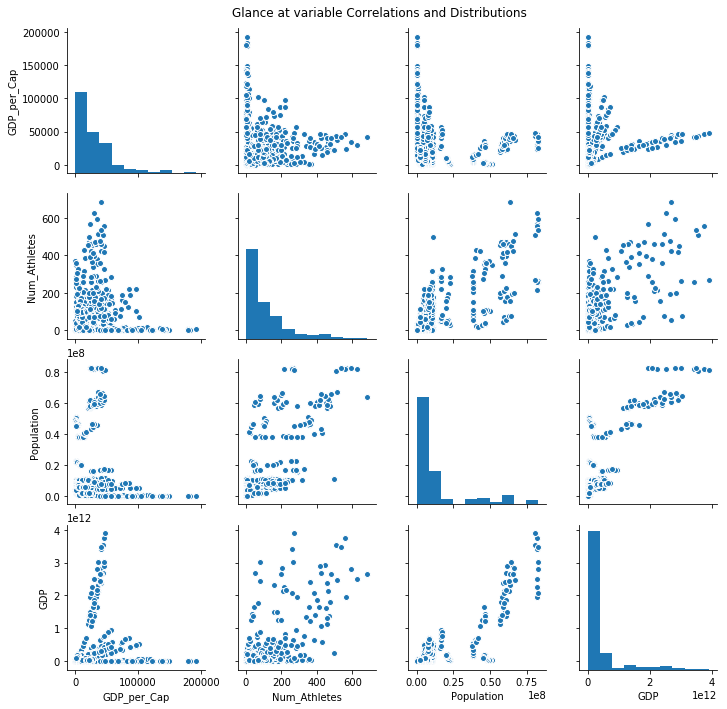

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.pairplot(grouped[['GDP_per_Cap','Num_Athletes','Population','GDP']])
plt.subplots_adjust(top=0.95)
plt.suptitle('Glance at variable Correlations and Distributions')
plt.show()


### Results 

   __Multiple Linear Regression Model: __

    Target ~ GDP + Population + Num_Athletes  
      
    Scores: R-squared: 0.79, RMSE: 10.9
    
   __ Random Forests Model:__
    
    Parameters: n_estimators = 21, max_features = 4
    
    Scores: R-squared: 0.81, RMSE: 9.1 
    
Seemingly superior results, but sensitive to random state initialisation
    
    RF Feature importances: 
    1) Num_Athletes: 0.65, 2) Population: 0.14, 3) GDP: 0.12, 4) GDP_per_Cap: 0.05, 5) Season: 0.04

__Conclusion:__ Approx. 80% of medals awarded to a country can be explained by the independent variables included in the model. 

### Further work 
In order to improve predictions would need more data, for instance:

- Complete world-wide GDP and population data would also be a helpful addition, albeit very hard to get!


- Complete human development index data 


- For 1st problem, detailed athlete-specific data about body metrics, training, lifestyle, etc.


- For 2nd problem, could try to add average athletes height by nation.  

### Conclusions

<br>
Key findings:

- Strong relationship between country size (GDP and population), Olympic participation and the number of medals won exists.
    - This is so strong that, 80% of medals a country will wins can be explained by the predictor features.
    

- A successful model to predict if a given athlete will win a medal cannot be built using only this data set.

<h1><centre>



<h1><center> 
<br>
The End 
<br><br>
<br>Thank you for listening </center></h1>

### Sources :

[1] The Telegraph *Mapped: The world's tallest (and shortest) countries*: https://www.telegraph.co.uk/travel/maps-and-graphics/the-tallest-and-shortest-countries-in-the-world/<br>

Data sources: 
Olympic dataset: https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results <br>
GDP data: https://www.kaggle.com/chadalee/country-wise-gdp-data<br>
Population data: https://www.kaggle.com/gemartin/world-bank-data-1960-to-2016<br>

#### Other (used for mini literature review):

- Randi H Griffin Olympic history data: thorough analysis:https://www.kaggle.com/heesoo37/olympic-history-data-a-thorough-analysis/report<br>

- Debadri Dutta Analysing the Olympics (for last 120 yrs.): https://www.kaggle.com/duttadebadri/analysing-the-olympics-for-last-120-yrs<br>

- Arunsankar Kumarakurubaran Key Insights from Olympic history data: https://www.kaggle.com/arunsankar/key-insights-from-olympic-history-data<br>

- Marco Giuseppe de Pinto Let's discover more about the Olympic Games!: https://www.kaggle.com/marcogdepinto/let-s-discover-more-about-the-olympic-games<br>

- Dheerendra Singh Tomar Progress of India in the history of Olympic games: https://www.kaggle.com/tomardheerendra/progress-of-india-in-the-history-of-olympic-games<br>

- Pakistan Timeline and History Overview: https://www.ducksters.com/geography/country/pakistan_history_timeline.php
<br>

- European Population data https://en.wikipedia.org/wiki/List_of_European_countries_by_population
